In [916]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

binance_path = "/Users/ilyat/Documents/quant📈/ccxt_data/data/binance/ohlc/perps/combined_enriched.csv"
bybit_path = "/Users/ilyat/Documents/quant📈/ccxt_data/data/bybit/ohlc/perps/combined_enriched.csv"
hyperliquid_path = "/Users/ilyat/Documents/quant📈/ccxt_data/data/hyperliquid/ohlc/perps/combined_enriched.csv"

df = pd.read_csv(bybit_path)
df = df.sort_values(by=['timestamp'])
df.timestamp = pd.to_datetime(df.timestamp)

# Join cci30

In [888]:
df.columns

Index(['symbol', 'timestamp', 'open', 'high', 'low', 'close', 'volume',
       'market_cap', 'fundingRate', 'buy_volume_ratio', 'Buy_Trades',
       'Total_Trades'],
      dtype='object')

In [889]:
cci30 = pd.read_csv('../data/CCi30 OHLCV Data.csv')
cci30.rename(columns={'Date': 'timestamp', 'Open':'open', 'Low':'low','High':'high', 'Close':'close', 'Volume':'volume'}, inplace=True)
cci30.columns

Index(['timestamp', 'open', 'high', 'low', 'close', 'volume'], dtype='object')

In [890]:
cci30['symbol'] = 'cci30'

# add the “missing” columns, all NaN
for col in ['market_cap','fundingRate','buy_volume_ratio','Buy_Trades','Total_Trades']:
    cci30[col] = np.nan

# 2) reorder columns to match your perps‐ohlc df exactly
cci30_rows = cci30[df.columns]

# 3) concatenate
df_all = pd.concat([df, cci30_rows], ignore_index=True)

df_all['timestamp'] = pd.to_datetime(df_all['timestamp'])

# 4) (optional) sort if you like
# df_all = df_all.sort_values('timestamp').reset_index(drop=True)
df_all = df_all.sort_values(by=['timestamp'])

In [891]:
df = df_all

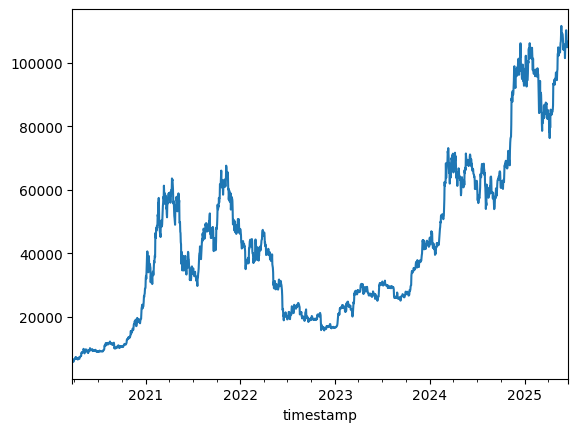

<Axes: xlabel='timestamp'>

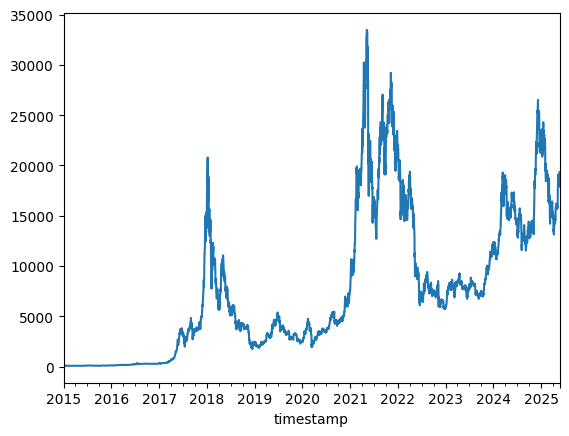

In [892]:
df[df.symbol == 'BTC'].set_index('timestamp')['close'].plot()
plt.show()
df[df.symbol == 'cci30'].set_index('timestamp')['close'].plot()

# Filter dates

In [893]:
df = df[df.timestamp >= '2023-01-01']
# df = df[df.timestamp <= '2025-01-01'] # ADD THIS

# Shorting high negative idio returns


- calculate beta to BTC
- find expected return given beta, if idio return < -20%, short signal.

In [894]:
df.columns

Index(['symbol', 'timestamp', 'open', 'high', 'low', 'close', 'volume',
       'market_cap', 'fundingRate', 'buy_volume_ratio', 'Buy_Trades',
       'Total_Trades'],
      dtype='object')

# Calculate idio returns

In [895]:
import pandas as pd

# compute simple returns first
df['return'] = df.groupby('symbol')['close'].pct_change()

# 1. make sure your timestamp is a datetime and data are sorted
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(['symbol','timestamp'])

hedge_symbol = 'BTC'

# 2. extract hedge_symbol's return series
btc = (
    df[df['symbol']==hedge_symbol]
    .loc[:, ['timestamp','return']]
    .rename(columns={'return':'btc_return'})
    .set_index('timestamp')
)

# 3. merge hedge_symbol's return onto every coin’s row
df['btc_return'] = df['timestamp'].map(btc['btc_return'])

# 4. compute BTC’s EWM variance on its own timeline, require ≥ span obs
span = 250
btc_ewm_var = (
    btc['btc_return']
    .ewm(span=span, adjust=False, min_periods=span)
    .var()
    .rename('btc_ewm_var')
)

# 5. map BTC’s EWM variance back to the main df
df['btc_ewm_var'] = df['timestamp'].map(btc_ewm_var)

# 6. for each coin, compute the EWM covariance with BTC, require ≥ span obs
df['btc_ewm_cov'] = (
    df
    .groupby('symbol')
    .apply(lambda g: g['return']
                       .ewm(span=span, adjust=False, min_periods=span)
                       .cov(g['btc_return']))
    .droplevel(0)
)

# 7. finally, EWM beta = EWM cov / EWM var
df['beta_ewm'] = ((df['btc_ewm_cov'] / df['btc_ewm_var'] ) + 1.3)/2

# 8. compute idiosyncratic return
df['idio_return'] = df['return'] - df['beta_ewm'] * df['btc_return']

# you can drop the intermediates if you like
df.drop(columns=['btc_ewm_cov', 'btc_ewm_var'], inplace=True)


/var/folders/x8/tfjs4htd20b9_gw42b2zzvxc0000gn/T/ipykernel_1571/1761340279.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['return'] = df.groupby('symbol')['close'].pct_change()
/var/folders/x8/tfjs4htd20b9_gw42b2zzvxc0000gn/T/ipykernel_1571/1761340279.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp'] = pd.to_datetime(df['timestamp'])
/var/folders/x8/tfjs4htd20b9_gw42b2zzvxc0000gn/T/ipykernel_1571/1761340279.py:39: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping 

# Event study

0.15


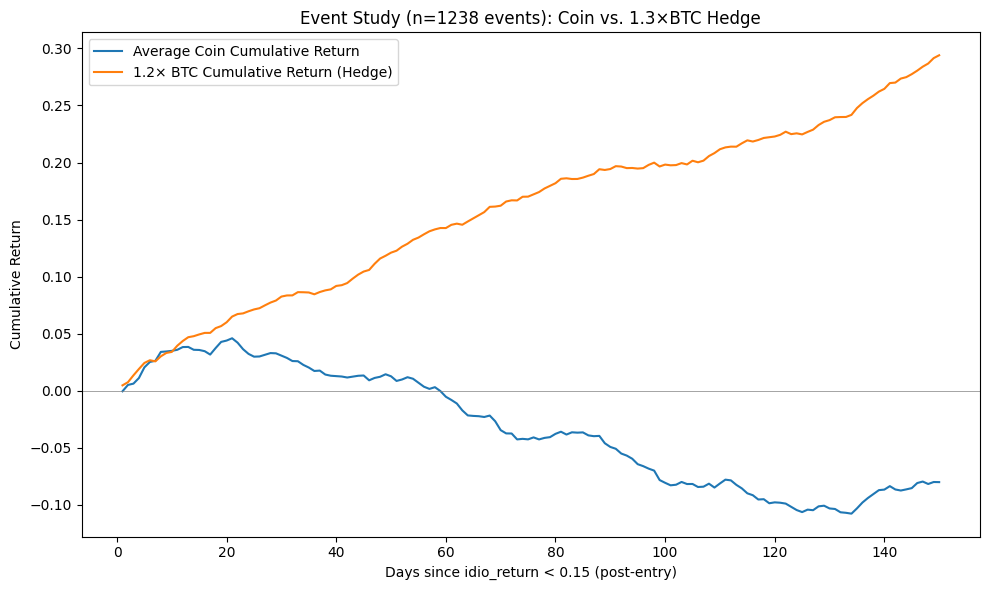

In [910]:
import numpy as np
import matplotlib.pyplot as plt

for threshold in [0.15]:
	# threshold = -threshold
	print(threshold)

	# 1. collect event‐window returns for coins and BTC, skipping day 0
	event_windows = []
	btc_windows   = []

	for symbol, g in df.groupby('symbol'):
		# ensure group is sorted by timestamp
		ret  = g['return'].values
		idio = g['idio_return'].values
		btc  = g['btc_return'].values
		
		# scan for events
		for i in range(len(ret)):
			# need room for days 1 through 100 after i
			if idio[i] > threshold and i + 150 < len(ret):
				# skip ret[i] and btc[i] (the entry-day)
				event_windows.append(ret[i+1:i+151])
				btc_windows.append(btc[i+1:i+151])

	# 2. stack into arrays (n_events × 150 days)
	if not event_windows:
		raise ValueError("No idio_return < threshold events found.")
	arr_coin = np.vstack(event_windows)
	arr_btc  = np.vstack(btc_windows)

	n_events = arr_coin.shape[0]

	# 3. compute average return at each horizon, then cumulate
	avg_ret_coin = arr_coin.mean(axis=0)    # shape (100,)
	avg_ret_btc  = arr_btc.mean(axis=0)     # shape (100,)

	cum_coin = np.cumsum(avg_ret_coin)      # length 100
	cum_btc  = np.cumsum(avg_ret_btc) * 1.2 # scale hedge by 1.3

	# 4. plot both
	days = np.arange(1, 151)  # days 1–100 after entry
	plt.figure(figsize=(10,6))
	plt.plot(days, cum_coin, label='Average Coin Cumulative Return')
	plt.plot(days, cum_btc,  label='1.2× BTC Cumulative Return (Hedge)')
	plt.axhline(0, color='gray', linewidth=0.5)
	plt.xlabel(f'Days since idio_return < {threshold} (post-entry)')
	plt.ylabel('Cumulative Return')
	plt.title(f'Event Study (n={n_events} events): Coin vs. 1.3×BTC Hedge')
	plt.legend()
	plt.tight_layout()
	plt.show()


# Calculate signal

In [911]:
# assume df is already sorted by ['symbol','timestamp']

def make_signal2(g):
    ts = g['timestamp']
    # mark where idio_return < -0.15
    events = g['idio_return'] > 0.2

    # build a Series of event dates
    last_evt = pd.Series(
        np.where(events, ts, pd.NaT),
        index=g.index,
        dtype='datetime64[ns]'
    ).ffill()

    # days since last event
    days_since = (ts - last_evt).dt.days

    # –1 while days_since is between 0 and 100 inclusive
    return pd.Series(
        np.where((days_since >= 0) & (days_since <= 100), -1, 0),
        index=g.index
    )

# apply per symbol
df['signal'] = (
    df
    .groupby('symbol')
    .apply(make_signal2)
    .droplevel(0)
)


/var/folders/x8/tfjs4htd20b9_gw42b2zzvxc0000gn/T/ipykernel_1571/3135965586.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(make_signal2)


<Axes: >

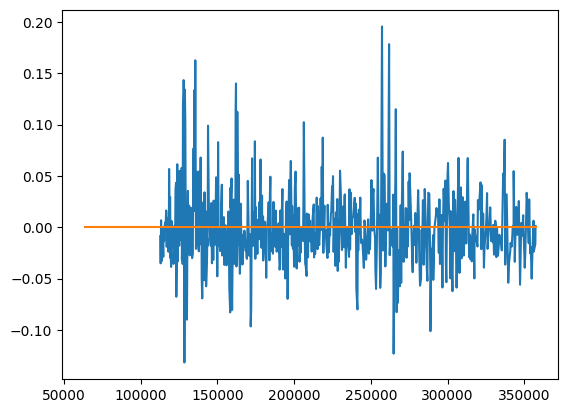

In [912]:
coin = df[df.symbol=='AVAX']
coin['idio_return'].plot()
# plt.show()
coin['signal'].plot()

# Avg Beta estimate

In [ ]:
# import pandas as pd
# import numpy as np

# # --- Filter the date range ---------------------------------------------------
# # df = df[(df.timestamp > '2023-01-01') & (df.timestamp < '2025-01-01')]
# # df = df[(df.timestamp > '2024-01-01')]

# # --- 1. Ensure simple returns exist -----------------------------------------
# if 'ret' not in df.columns:
#     df['ret'] = df.groupby('symbol')['close'].pct_change()

# # --- 2. Get BTC returns -----------------------------------------------------
# hedge_symbol = 'BTC'
# btc_ret = (
#     df[df['symbol'] == hedge_symbol]
#     .set_index('timestamp')['ret']
#     .rename('btc_ret')
# )

# # --- 3. Select only signal == -1 coins --------------------------------------
# signal_df = df[
#     (df['symbol'] != hedge_symbol) &
#     (df['signal'] == -1)
# ][['timestamp', 'symbol', 'ret']]

# # --- 4. Pivot to wide, align with BTC returns -------------------------------
# rets_signal = signal_df.pivot(
#     index='timestamp',
#     columns='symbol',
#     values='ret'
# )
# data = rets_signal.join(btc_ret, how='inner')  # only timestamps where BTC has a ret

# # --- 5. Compute β for each symbol in the signal window ----------------------
# betas = {}

# for sym in rets_signal.columns:
#     sub = data[[sym, 'btc_ret']].dropna()
#     # need at least 2 points and nonzero BTC variance
#     if len(sub) > 1 and sub['btc_ret'].var(ddof=1) > 0:
#         cov = sub[sym].cov(sub['btc_ret'])
#         var = sub['btc_ret'].var(ddof=1)
#         betas[sym] = cov / var

# betas = pd.Series(betas, name='beta_to_btc')

# # --- 6. Compute and print the average β --------------------------------------
# print(f"Computed betas for {len(betas)} symbols in their signal == -1 windows.\n")
# print(f"Mean β to BTC:   {betas.mean():.4f}")
# print(f"Median β to BTC: {betas.median():.4f}")

# # (Optional) inspect the full distribution
# print("\nIndividual symbol betas:")
# print(betas.sort_values())


# Volatility

In [914]:
# Calculate volatility
df['vol_expanding_window'] = (
	df.groupby('symbol')['return']
		.transform(lambda x: x
					.expanding(min_periods=30)
					.std())
)
df['vol_ewm'] = (
	df.groupby('symbol')['return']
		.transform(lambda x: x
					.ewm(span=30, adjust=False, min_periods=30)
					.std())
)
df['volatility'] = (
	df['vol_expanding_window'] * 0.25 +
	df['vol_ewm'] * 0.75
)

df['volatility'].clip(lower=0.1, inplace=True)  # avoid very low volatilities

/var/folders/x8/tfjs4htd20b9_gw42b2zzvxc0000gn/T/ipykernel_1571/3272798486.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['volatility'].clip(lower=0.1, inplace=True)  # avoid very low volatilities


# Backtest Equal weight


/var/folders/x8/tfjs4htd20b9_gw42b2zzvxc0000gn/T/ipykernel_1571/2497564055.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_daily_equal_short_weights)


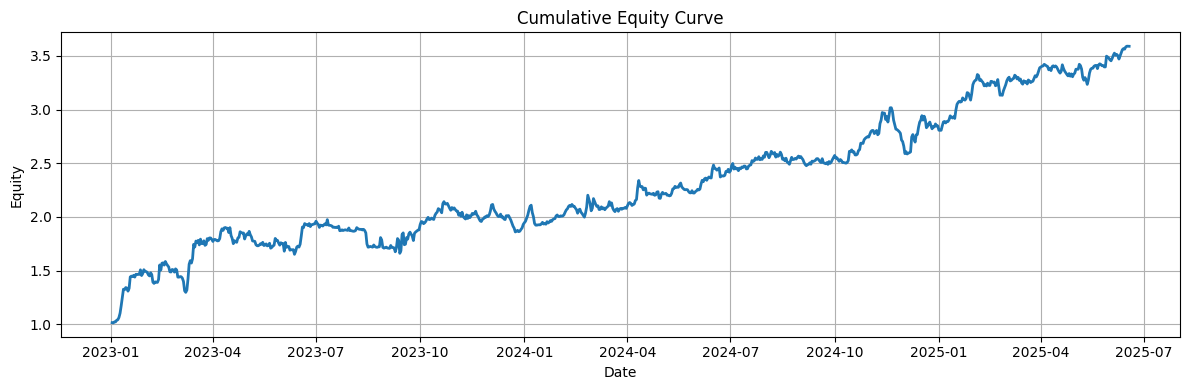

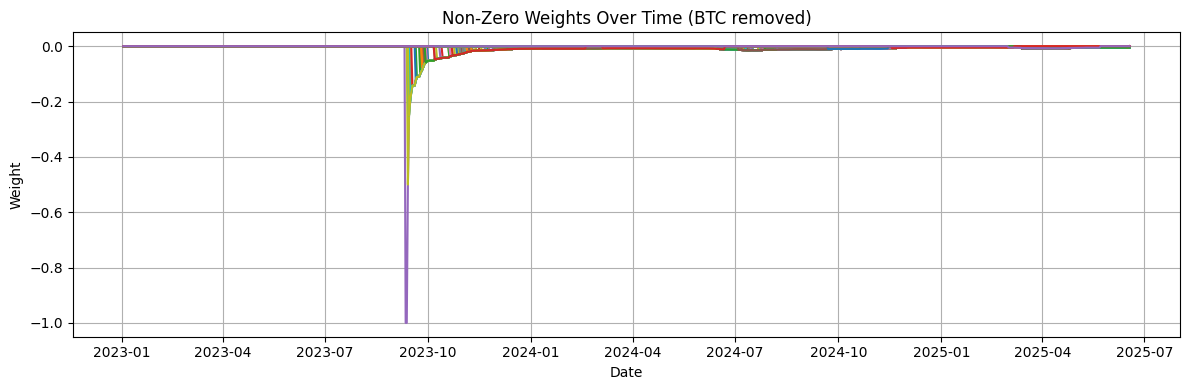

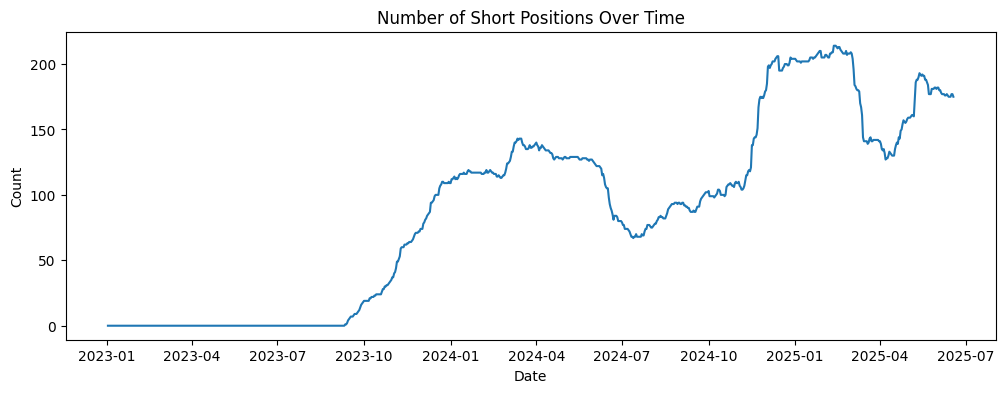

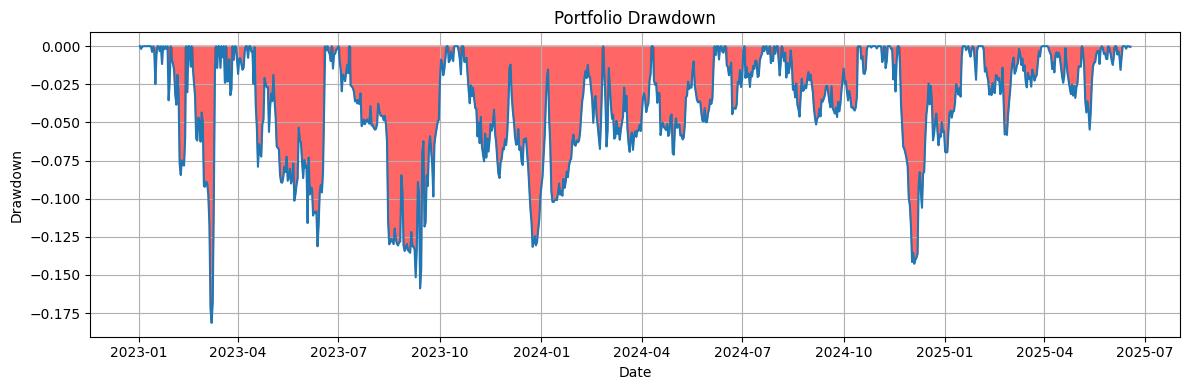

1.80 annualized Sharpe ratio


In [906]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Prep -----------------------------------------------------------------
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(['timestamp', 'symbol'])

df = df[df.timestamp>'2023-01-01']

# --- 2. Compute daily pct returns -------------------------------------------
df['ret'] = df.groupby('symbol')['close'].pct_change()
# RET IS NOW THE RETURN from T-1 TO T
# THE WEIGHT IS DECIDED ON DAY T
# SO WE NEED TO LAG THE RETURNS BY ONE DAY TO BE FROM T TO T+1
# WE DO THIS WITH rets_lag = rets_df.shift(-1).fillna(0)

# --- 3. Equal-weight short signals ------------------------------------------
def _daily_equal_short_weights(day):
    shorts = day['signal'] == -1
    n = shorts.sum()
    if n > 0:
        return pd.Series(np.where(shorts, -1/n, 0.0), index=day.index)
    else:
        return pd.Series(0.0, index=day.index)

df['weight'] = (
    df.groupby('timestamp', group_keys=False)
      .apply(_daily_equal_short_weights)
)

# --- 4. Pivot weights & lagged returns -------------------------------------
weights_df = df.pivot(index='timestamp', columns='symbol', values='weight').fillna(0)
weights_df['BTC'] = 1.4
rets_df    = df.pivot(index='timestamp', columns='symbol', values='ret').fillna(0)

# lag returns by one period to avoid lookahead
rets_lag = rets_df.shift(-1).fillna(0)

# --- 5. Compute portfolio returns & equity ---------------------------------
port_ret = (weights_df * rets_lag).sum(axis=1).rename('port_ret')
# port_ret = port_ret*4
equity = (1 + port_ret.cumsum()).rename('cum_equity')

# --- 6. Plot equity curve & non-zero weights in one figure -----------------
import matplotlib.pyplot as plt

# --- Plot 1: Cumulative Equity Curve ---------------------------------------
plt.figure(figsize=(12, 4))
plt.plot(equity.index, equity, lw=2)
plt.title('Cumulative Equity Curve')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 2: Non-Zero Weights Over Time (BTC removed) ----------------------
nz = (weights_df
      .drop(columns='BTC', errors='ignore')
      .loc[:, lambda x: (x != 0).any(axis=0)])

plt.figure(figsize=(12, 4))
for sym in nz.columns:
    plt.plot(nz.index, nz[sym])
plt.title('Non-Zero Weights Over Time (BTC removed)')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: number of short positions
plt.figure(figsize=(12, 4))
plt.plot(nz.index, (nz != 0).sum(axis=1), lw=1.5)
plt.title('Number of Short Positions Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.show()


# --- Plot 3: Portfolio Drawdown --------------------------------------------
running_max = equity.cummax()
drawdown = (equity / running_max) - 1

plt.figure(figsize=(12, 4))
plt.fill_between(drawdown.index, drawdown, 0, where=drawdown < 0, color='red', alpha=0.6)
plt.plot(drawdown.index, drawdown, lw=1.5)
plt.title('Portfolio Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"{(port_ret.mean()/port_ret.std())*np.sqrt(365):.2f} annualized Sharpe ratio")

# # Save the portfolio returns to a CSV file
# name = "falling_knives_cci30_idio"
# port_ret.rename(name).to_csv(f'../data/backtests/{name}.csv', header=True)


# Equal risk backtest

/var/folders/x8/tfjs4htd20b9_gw42b2zzvxc0000gn/T/ipykernel_1571/85027158.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_daily_risk_short_weights)


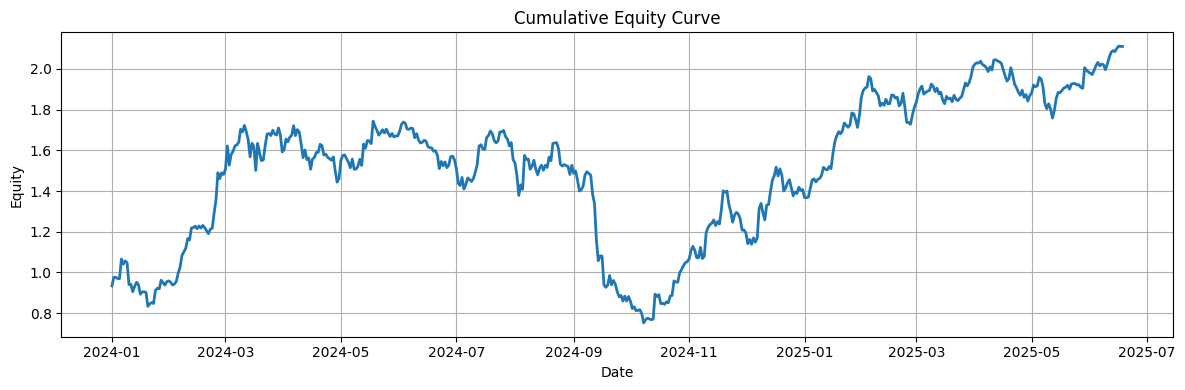

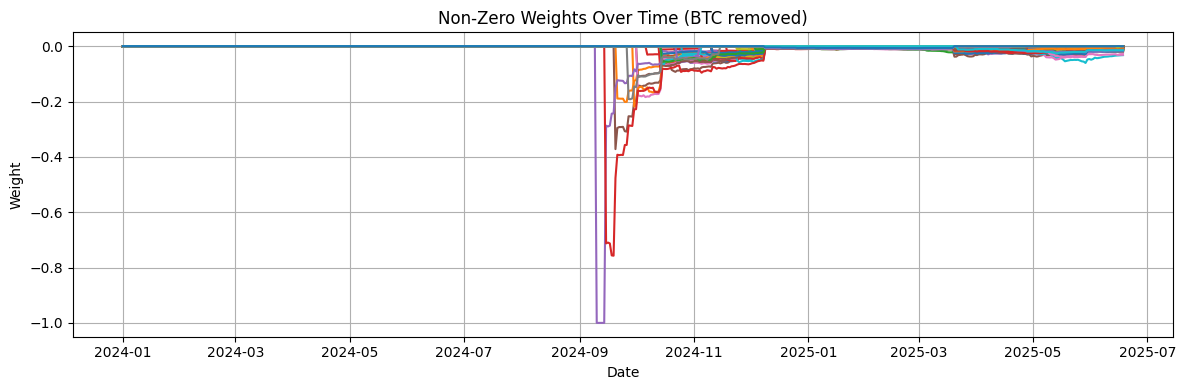

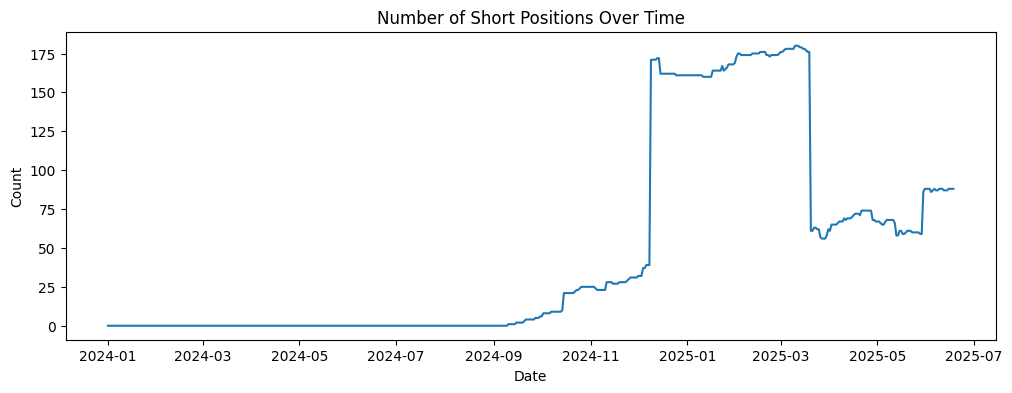

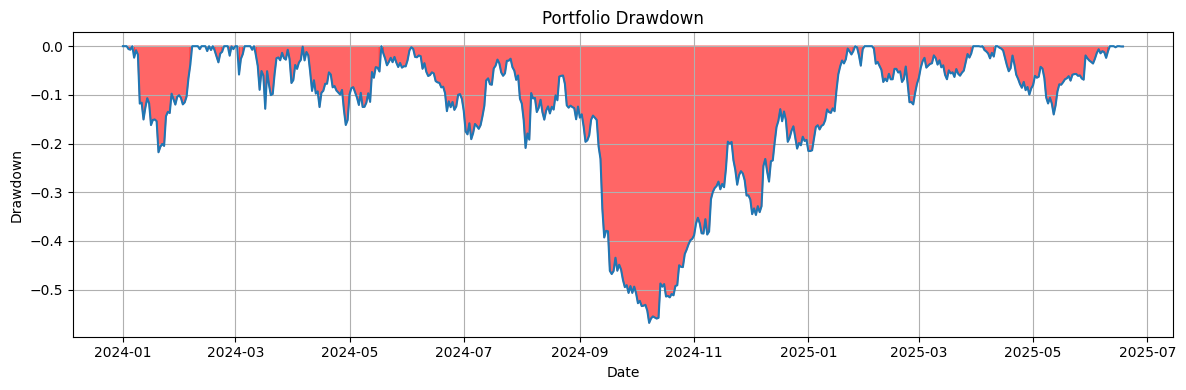

1.03 annualized Sharpe ratio


In [793]:
# --- 1. Prep -----------------------------------------------------------------
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(['timestamp', 'symbol'])
df = df[df.timestamp > '2023-01-01']

# --- 2. Compute daily pct returns -------------------------------------------
df['ret'] = df.groupby('symbol')['close'].pct_change()

# compute a 30-day rolling volatility per symbol (you can change window!)
vol_window = 30
df['volatility'] = (
    df.groupby('symbol')['ret']
      .rolling(vol_window)
      .std()
      .reset_index(level=0, drop=True)
)

# --- 3. Risk-weighted short signals -----------------------------------------
def _daily_risk_short_weights(day):
    is_short = day['signal'] == -1
    # pick up vols for those shorts, drop zeros/nans
    v = day.loc[is_short, 'volatility'].replace(0, np.nan).dropna()
    if not v.empty:
        inv_v = 1.0 / v
        w_s = -(inv_v / inv_v.sum())    # sums to -1
        w = pd.Series(0.0, index=day.index)
        w.loc[w_s.index] = w_s
        return w
    else:
        return pd.Series(0.0, index=day.index)

df['weight'] = (
    df.groupby('timestamp', group_keys=False)
      .apply(_daily_risk_short_weights)
)

# --- 4. Pivot weights & lagged returns -------------------------------------
weights_df = df.pivot(index='timestamp', columns='symbol', values='weight').fillna(0)
weights_df['BTC'] = 1.4
rets_df    = df.pivot(index='timestamp', columns='symbol', values='ret').fillna(0)

# lag returns by one period to avoid lookahead
rets_lag = rets_df.shift(-1).fillna(0)

# --- 5. Compute portfolio returns & equity ---------------------------------
port_ret = (weights_df * rets_lag).sum(axis=1).rename('port_ret')
equity   = (1 + port_ret.cumsum()).rename('cum_equity')

# --- 6. Plot equity curve & non-zero weights in one figure -----------------
import matplotlib.pyplot as plt

# --- Plot 1: Cumulative Equity Curve ---------------------------------------
plt.figure(figsize=(12, 4))
plt.plot(equity.index, equity, lw=2)
plt.title('Cumulative Equity Curve')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot 2: Non-Zero Weights Over Time (BTC removed) ----------------------
nz = (weights_df
      .drop(columns='BTC', errors='ignore')
      .loc[:, lambda x: (x != 0).any(axis=0)])

plt.figure(figsize=(12, 4))
for sym in nz.columns:
    plt.plot(nz.index, nz[sym])
plt.title('Non-Zero Weights Over Time (BTC removed)')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 3: number of short positions
plt.figure(figsize=(12, 4))
plt.plot(nz.index, (nz != 0).sum(axis=1), lw=1.5)
plt.title('Number of Short Positions Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.show()


# --- Plot 3: Portfolio Drawdown --------------------------------------------
running_max = equity.cummax()
drawdown = (equity / running_max) - 1

plt.figure(figsize=(12, 4))
plt.fill_between(drawdown.index, drawdown, 0, where=drawdown < 0, color='red', alpha=0.6)
plt.plot(drawdown.index, drawdown, lw=1.5)
plt.title('Portfolio Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"{(port_ret.mean()/port_ret.std())*np.sqrt(365):.2f} annualized Sharpe ratio")

# # Save the portfolio returns to a CSV file
# name = "falling_knives_cci30_idio"
# port_ret.rename(name).to_csv(f'../data/backtests/{name}.csv', header=True)


# Varying hedge


/var/folders/x8/tfjs4htd20b9_gw42b2zzvxc0000gn/T/ipykernel_1571/847832307.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['weight'] = df.groupby('timestamp', group_keys=False).apply(_daily_equal_short_weights)


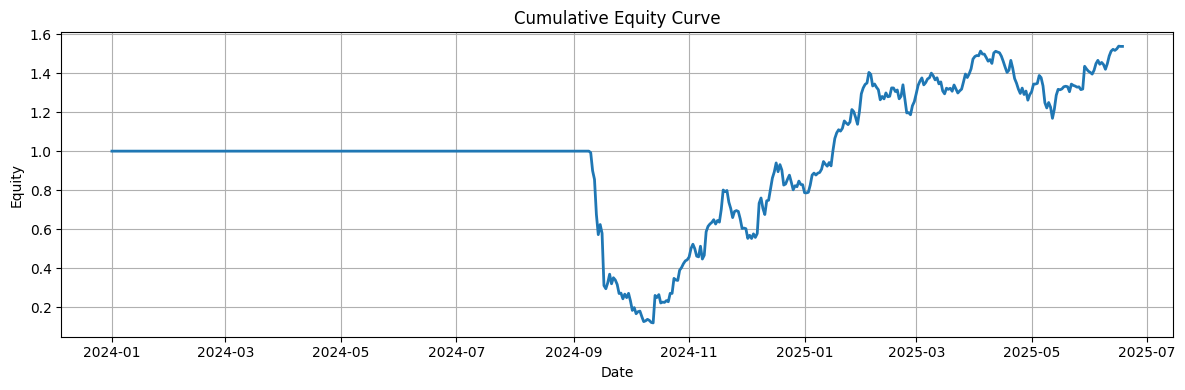

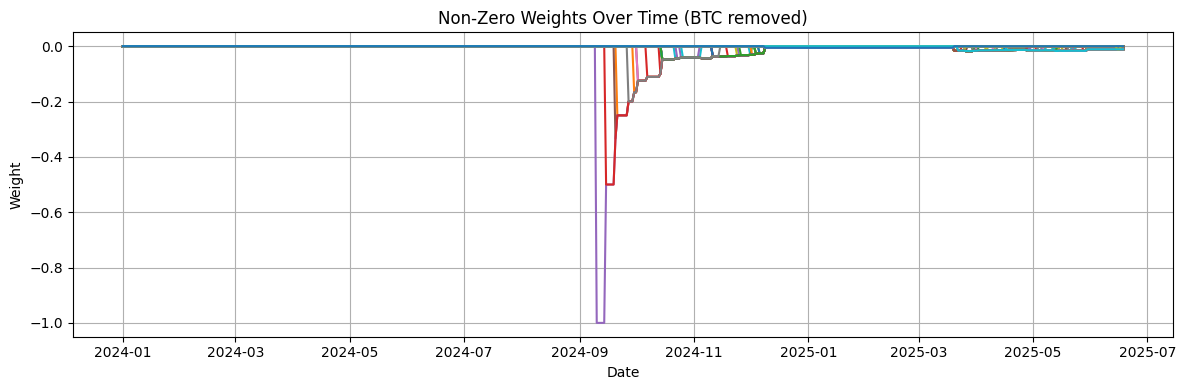

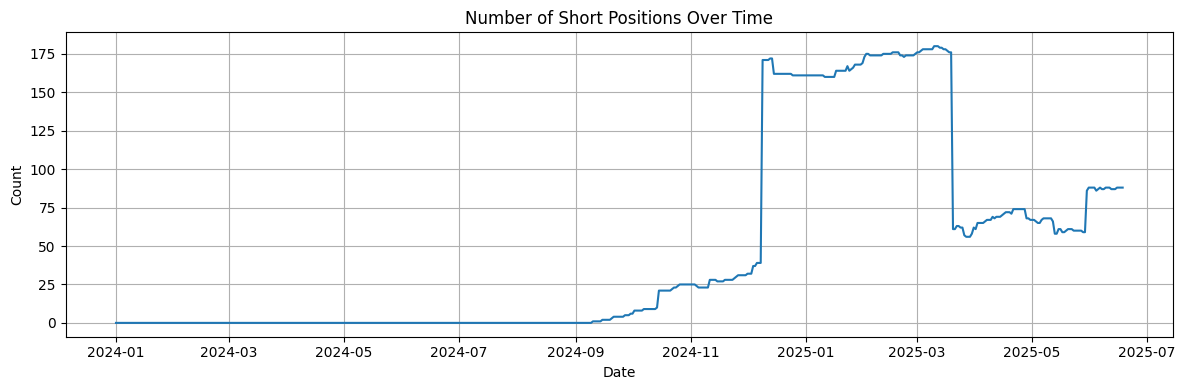

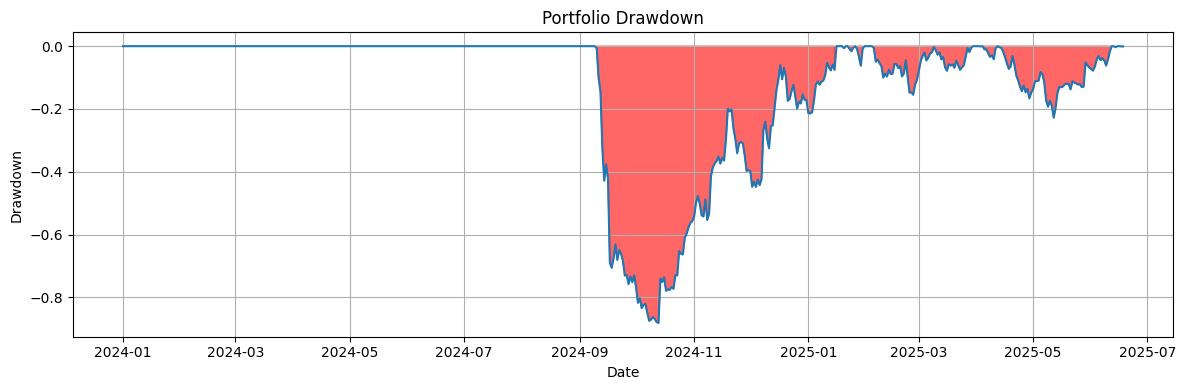

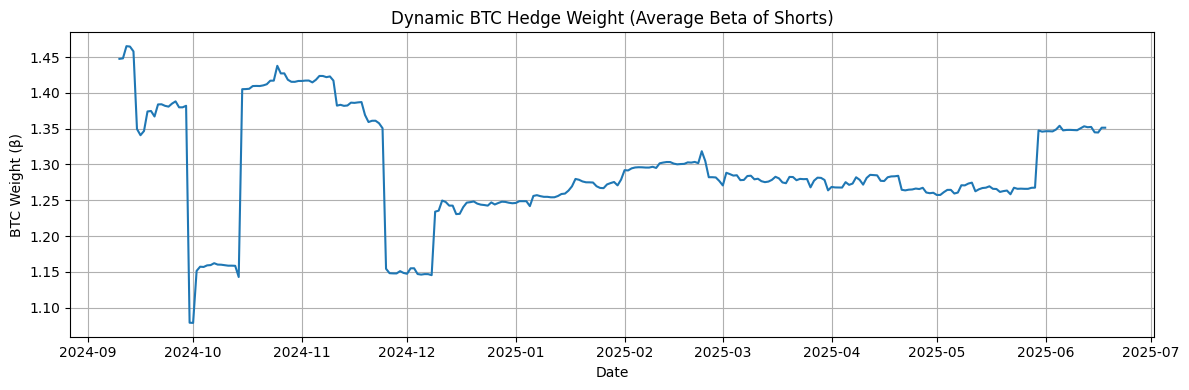

0.65 annualized Sharpe ratio


In [794]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Prep -----------------------------------------------------------------
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(['timestamp', 'symbol'])
df = df[df.timestamp > '2023-01-01']

# --- 2. Compute daily pct returns -------------------------------------------
df['ret'] = df.groupby('symbol')['close'].pct_change()

# --- 3. Equal-weight short signals ------------------------------------------
def _daily_equal_short_weights(day):
    shorts = (day['signal'] == -1)
    n = shorts.sum()
    if n > 0:
        return pd.Series(np.where(shorts, -1.0 / n, 0.0), index=day.index)
    else:
        return pd.Series(0.0, index=day.index)

df['weight'] = df.groupby('timestamp', group_keys=False).apply(_daily_equal_short_weights)

# --- 4. Compute dynamic BTC hedge weight (average beta of shorts) -----------
# assume you have a 'beta' column on df (rolling or EWM)
btc_weight = (
    df[df['signal'] == -1]
      .groupby('timestamp')['beta_ewm']
      .mean()
      .rename('btc_weight')
)

# --- 5. Pivot weights & returns, lag returns --------------------------------
weights_df = df.pivot(index='timestamp', columns='symbol', values='weight').fillna(0)
weights_df['BTC'] = btc_weight.reindex(weights_df.index).fillna(0)

rets_df    = df.pivot(index='timestamp', columns='symbol', values='ret').fillna(0)
rets_lag   = rets_df.shift(-1).fillna(0)

# --- 6. Compute portfolio returns & equity ----------------------------------
port_ret = (weights_df * rets_lag).sum(axis=1).rename('port_ret')
equity   = (1 + port_ret.cumsum()).rename('cum_equity')

# --- 7. Plot cumulative equity curve ----------------------------------------
plt.figure(figsize=(12, 4))
plt.plot(equity.index, equity, lw=2)
plt.title('Cumulative Equity Curve')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 8. Plot non-zero weights over time (BTC removed) ----------------------
nz = (weights_df
      .drop(columns='BTC')
      .loc[:, lambda x: (x != 0).any(axis=0)])

plt.figure(figsize=(12, 4))
for sym in nz.columns:
    plt.plot(nz.index, nz[sym])
plt.title('Non-Zero Weights Over Time (BTC removed)')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 9. Plot number of short positions --------------------------------------
plt.figure(figsize=(12, 4))
plt.plot(nz.index, (nz != 0).sum(axis=1), lw=1.5)
plt.title('Number of Short Positions Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 10. Plot portfolio drawdown --------------------------------------------
running_max = equity.cummax()
drawdown = (equity / running_max) - 1

plt.figure(figsize=(12, 4))
plt.fill_between(drawdown.index, drawdown, 0, where=drawdown < 0,
                 color='red', alpha=0.6)
plt.plot(drawdown.index, drawdown, lw=1.5)
plt.title('Portfolio Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 11. Plot dynamic BTC hedge weight (avg beta) ---------------------------
plt.figure(figsize=(12, 4))
plt.plot(btc_weight.index, btc_weight, lw=1.5)
plt.title('Dynamic BTC Hedge Weight (Average Beta of Shorts)')
plt.xlabel('Date')
plt.ylabel('BTC Weight (β)')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- 12. Annualised Sharpe -------------------------------------------------
print(f"{(port_ret.mean() / port_ret.std()) * np.sqrt(365):.2f} annualized Sharpe ratio")


# Risk-weight, varying hedge

/var/folders/x8/tfjs4htd20b9_gw42b2zzvxc0000gn/T/ipykernel_1571/322155503.py:36: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_risk_weights)
/var/folders/x8/tfjs4htd20b9_gw42b2zzvxc0000gn/T/ipykernel_1571/322155503.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda day: -(day['weight'] * day[beta_col]).sum())


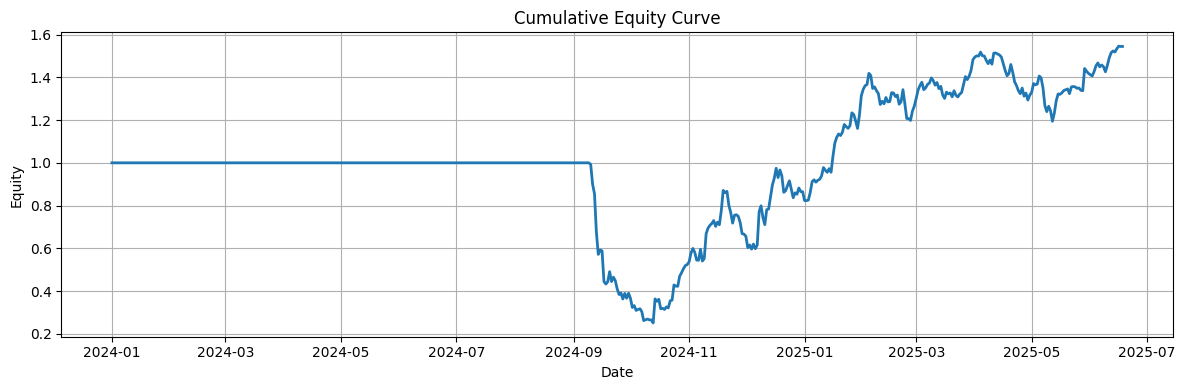

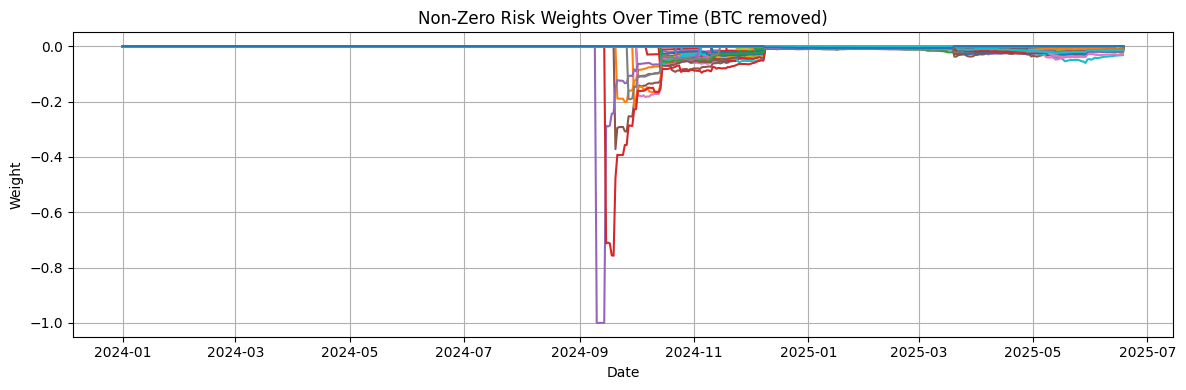

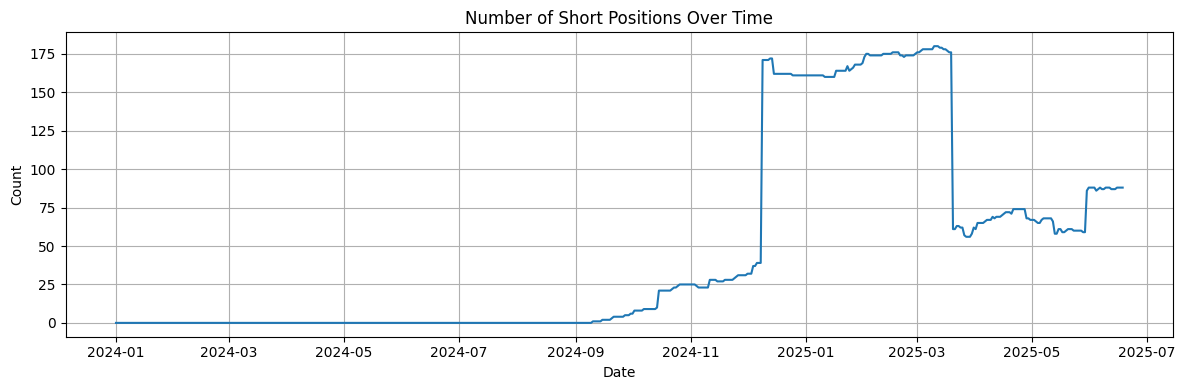

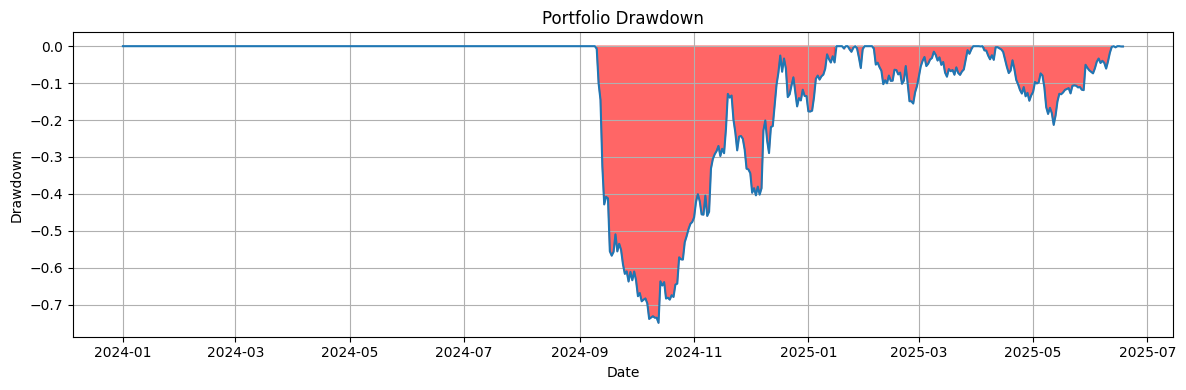

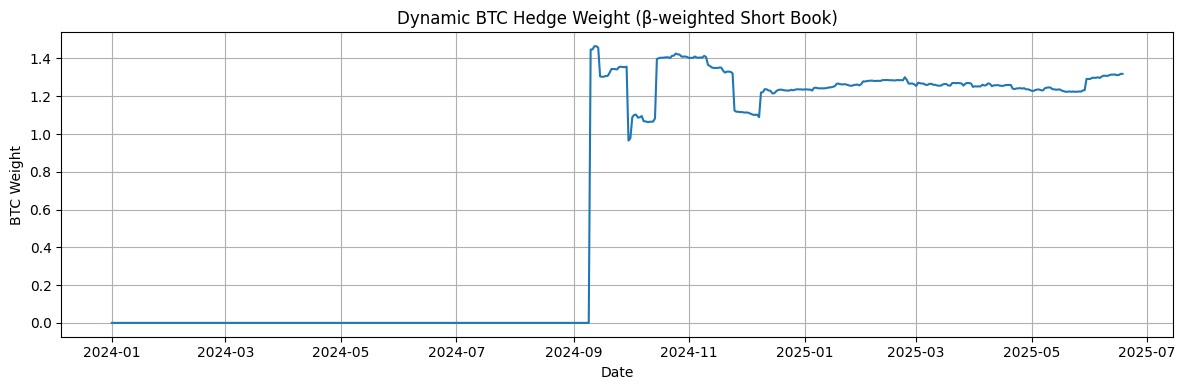

0.73 annualized Sharpe ratio


In [795]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------
# 1.  PREP
# ---------------------------------------------------------------------------
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(['timestamp', 'symbol'])
df = df[df.timestamp > '2023-01-01']          # back-test date filter

# ---------------------------------------------------------------------------
# 2.  DAILY RETURNS
# ---------------------------------------------------------------------------
df['ret'] = df.groupby('symbol')['close'].pct_change()   # from T-1 to T

# ---------------------------------------------------------------------------
# 3.  RISK-WEIGHTED SHORT BOOK  (sum(weights) = -1)
#     – weight_i = − (1 / vol_i) / Σ(1 / vol_j)   for all coins with signal = -1
# ---------------------------------------------------------------------------
def _risk_weights(day: pd.DataFrame) -> pd.Series:
    shorts = day['signal'] == -1
    if shorts.sum() == 0:
        return pd.Series(0.0, index=day.index)

    inv_vol = 1.0 / day.loc[shorts, 'volatility'].replace(0, np.nan)
    inv_vol = inv_vol.fillna(0.0)

    w = -inv_vol / inv_vol.sum()                # weights sum to -1
    out = pd.Series(0.0, index=day.index)
    out.loc[shorts] = w
    return out

df['weight'] = (
    df.groupby('timestamp', group_keys=False)
      .apply(_risk_weights)
)

# ---------------------------------------------------------------------------
# 4.  DYNAMIC BTC HEDGE WEIGHT  (offset the book’s β exactly)
#     btc_weight_t = − Σ_i weight_i,t × beta_i,t
# ---------------------------------------------------------------------------
beta_col = 'beta_ewm' if 'beta_ewm' in df.columns else 'beta'

btc_weight = (
    df.groupby('timestamp')
      .apply(lambda day: -(day['weight'] * day[beta_col]).sum())
      .rename('btc_weight')
)

# ---------------------------------------------------------------------------
# 5.  PIVOT WEIGHTS / RETURNS, LAG RETURNS
# ---------------------------------------------------------------------------
weights_df = df.pivot(index='timestamp', columns='symbol', values='weight').fillna(0.0)
weights_df['BTC'] = btc_weight.reindex(weights_df.index).fillna(0.0)

rets_df  = df.pivot(index='timestamp', columns='symbol', values='ret').fillna(0.0)
rets_lag = rets_df.shift(-1).fillna(0.0)                      # avoid look-ahead

# ---------------------------------------------------------------------------
# 6.  PORTFOLIO RETURNS & EQUITY CURVE
# ---------------------------------------------------------------------------
port_ret = (weights_df * rets_lag).sum(axis=1).rename('port_ret')
equity   = (1 + port_ret.cumsum()).rename('cum_equity')

# ---------------------------------------------------------------------------
# 7.  PLOTS
# ---------------------------------------------------------------------------

# (a) cumulative equity curve
plt.figure(figsize=(12, 4))
plt.plot(equity.index, equity, lw=2)
plt.title('Cumulative Equity Curve')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.grid(True)
plt.tight_layout()
plt.show()

# (b) non-zero risk weights over time (BTC removed)
nz = (weights_df
      .drop(columns='BTC', errors='ignore')
      .loc[:, lambda x: (x != 0).any(axis=0)])

plt.figure(figsize=(12, 4))
for sym in nz.columns:
    plt.plot(nz.index, nz[sym])
plt.title('Non-Zero Risk Weights Over Time (BTC removed)')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.grid(True)
plt.tight_layout()
plt.show()

# (c) number of short positions
plt.figure(figsize=(12, 4))
plt.plot(nz.index, (nz != 0).sum(axis=1), lw=1.5)
plt.title('Number of Short Positions Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()

# (d) portfolio drawdown
running_max = equity.cummax()
drawdown = (equity / running_max) - 1

plt.figure(figsize=(12, 4))
plt.fill_between(drawdown.index, drawdown, 0, where=drawdown < 0,
                 color='red', alpha=0.6)
plt.plot(drawdown.index, drawdown, lw=1.5)
plt.title('Portfolio Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.grid(True)
plt.tight_layout()
plt.show()

# (e) dynamic BTC hedge weight (β-adjusted)
plt.figure(figsize=(12, 4))
plt.plot(btc_weight.index, btc_weight, lw=1.5)
plt.title('Dynamic BTC Hedge Weight (β-weighted Short Book)')
plt.xlabel('Date')
plt.ylabel('BTC Weight')
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------
# 8.  ANNUALISED SHARPE
# ---------------------------------------------------------------------------
print(f"{(port_ret.mean() / port_ret.std()) * np.sqrt(365):.2f} annualized Sharpe ratio")


# Risk-weight, varing hedge, max 50 positions

/var/folders/x8/tfjs4htd20b9_gw42b2zzvxc0000gn/T/ipykernel_1571/1377584172.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: _risk_weights(d, cap=50))
/var/folders/x8/tfjs4htd20b9_gw42b2zzvxc0000gn/T/ipykernel_1571/1377584172.py:54: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda day: -(day['weight'] * day[beta_col]).sum())


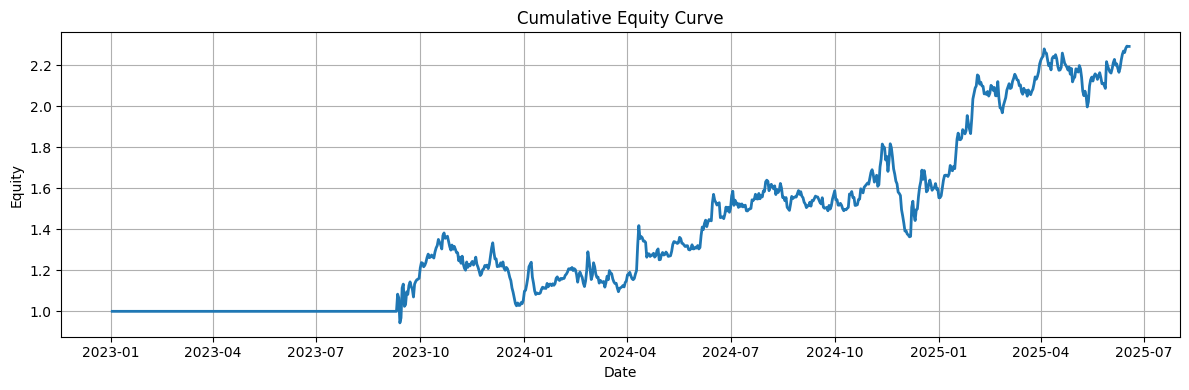

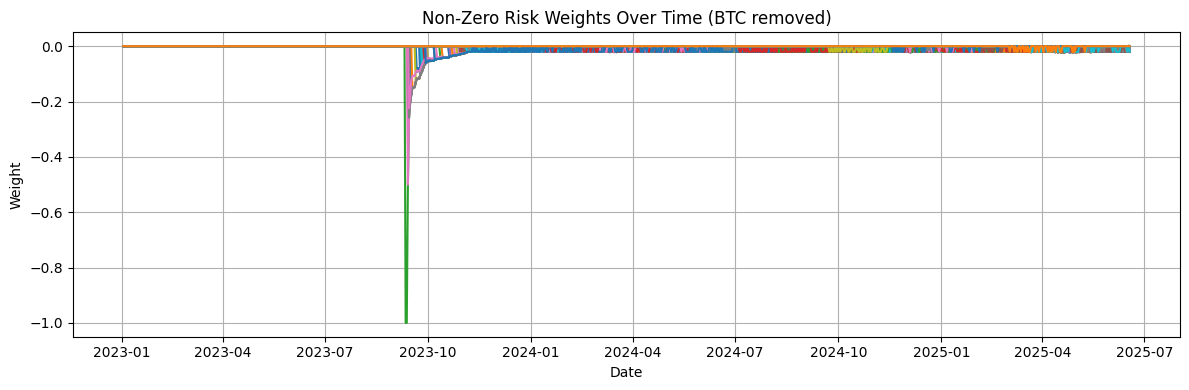

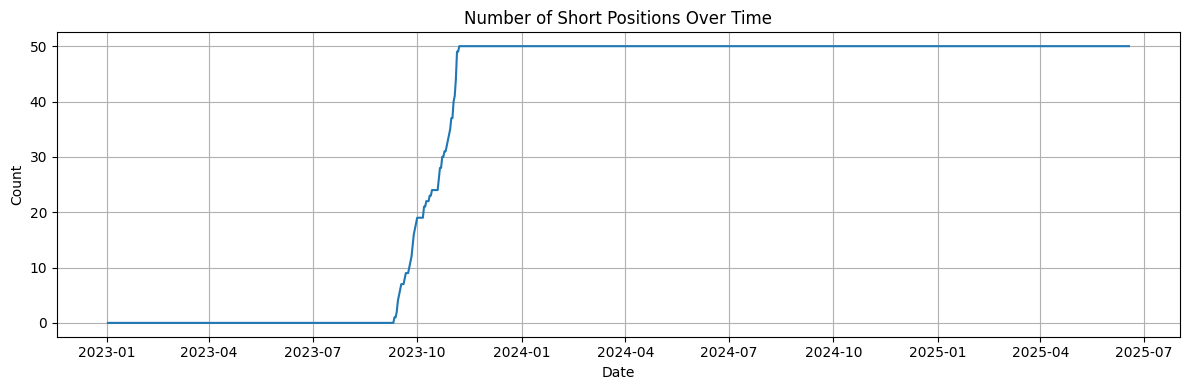

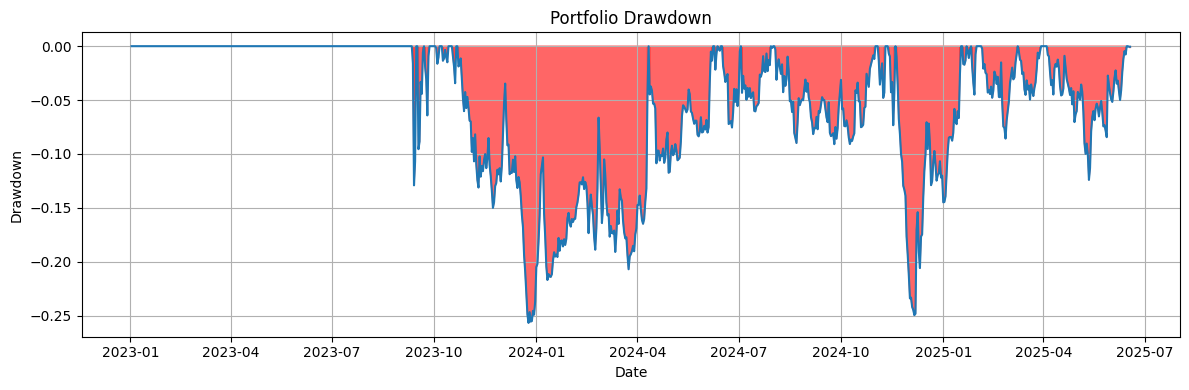

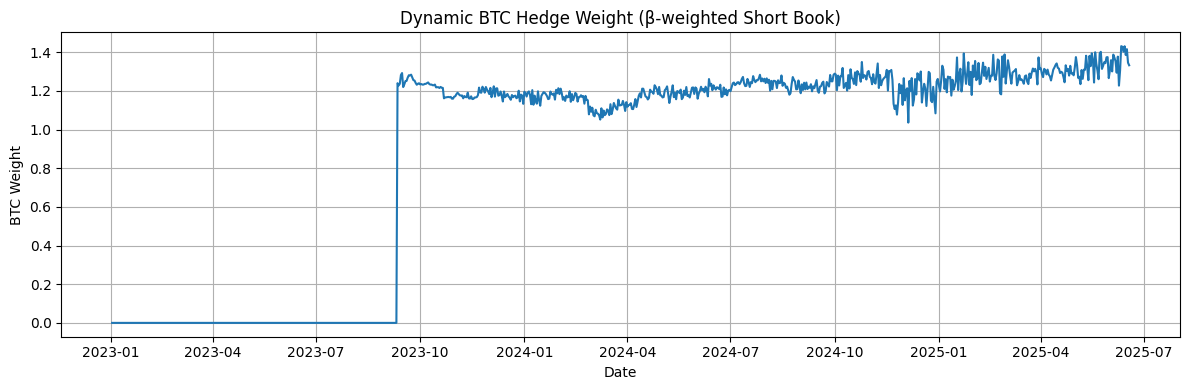

1.08 annualized Sharpe ratio


In [907]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------
# 1.  PREP
# ---------------------------------------------------------------------------
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(['timestamp', 'symbol'])
df = df[df.timestamp > '2023-01-01']          # back-test date filter

# ---------------------------------------------------------------------------
# 2.  DAILY RETURNS
# ---------------------------------------------------------------------------
df['ret'] = df.groupby('symbol')['close'].pct_change()   # from T-1 to T

# ---------------------------------------------------------------------------
# 3.  RISK-WEIGHTED SHORT BOOK  (sum(weights) = -1), capped at 50 positions
#     – weight_i = − (1 / vol_i) / Σ(1 / vol_j)   for the 50 worst idio_return shorts
# ---------------------------------------------------------------------------
def _risk_weights(day: pd.DataFrame, cap: int = 50) -> pd.Series:
    shorts = day['signal'] == -1
    if shorts.sum() == 0:
        return pd.Series(0.0, index=day.index)

    # pick up to `cap` coins with the lowest idio_return
    shorters = day.loc[shorts]
    to_keep = shorters.nsmallest(cap, 'idio_return').index

    # compute inverse-vol weights on that subset
    inv_vol = 1.0 / day.loc[to_keep, 'volatility'].replace(0, np.nan)
    inv_vol = inv_vol.fillna(0.0)

    w = -inv_vol / inv_vol.sum()  # sums to -1

    # full-day weight vector, zero for all others
    out = pd.Series(0.0, index=day.index)
    out.loc[to_keep] = w
    return out

df['weight'] = (
    df.groupby('timestamp', group_keys=False)
      .apply(lambda d: _risk_weights(d, cap=50))
)

# ---------------------------------------------------------------------------
# 4.  DYNAMIC BTC HEDGE WEIGHT  (offset the book’s β exactly)
#     btc_weight_t = − Σ_i weight_i,t × beta_i,t
# ---------------------------------------------------------------------------
beta_col = 'beta_ewm' if 'beta_ewm' in df.columns else 'beta'

btc_weight = (
    df.groupby('timestamp')
      .apply(lambda day: -(day['weight'] * day[beta_col]).sum())
      .rename('btc_weight')
)

# ---------------------------------------------------------------------------
# 5.  PIVOT WEIGHTS / RETURNS, LAG RETURNS
# ---------------------------------------------------------------------------
weights_df = df.pivot(index='timestamp', columns='symbol', values='weight').fillna(0.0)
weights_df['BTC'] = btc_weight.reindex(weights_df.index).fillna(0.0)

rets_df  = df.pivot(index='timestamp', columns='symbol', values='ret').fillna(0.0)
rets_lag = rets_df.shift(-1).fillna(0.0)                      # avoid look-ahead

# ---------------------------------------------------------------------------
# 6.  PORTFOLIO RETURNS & EQUITY CURVE
# ---------------------------------------------------------------------------
port_ret = (weights_df * rets_lag).sum(axis=1).rename('port_ret')
equity   = (1 + port_ret.cumsum()).rename('cum_equity')

# ---------------------------------------------------------------------------
# 7.  PLOTS
# ---------------------------------------------------------------------------

# (a) cumulative equity curve
plt.figure(figsize=(12, 4))
plt.plot(equity.index, equity, lw=2)
plt.title('Cumulative Equity Curve')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.grid(True)
plt.tight_layout()
plt.show()

# (b) non-zero risk weights over time (BTC removed)
nz = (weights_df
      .drop(columns='BTC', errors='ignore')
      .loc[:, lambda x: (x != 0).any(axis=0)])

plt.figure(figsize=(12, 4))
for sym in nz.columns:
    plt.plot(nz.index, nz[sym])
plt.title('Non-Zero Risk Weights Over Time (BTC removed)')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.grid(True)
plt.tight_layout()
plt.show()

# (c) number of short positions
plt.figure(figsize=(12, 4))
plt.plot(nz.index, (nz != 0).sum(axis=1), lw=1.5)
plt.title('Number of Short Positions Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()

# (d) portfolio drawdown
running_max = equity.cummax()
drawdown = (equity / running_max) - 1

plt.figure(figsize=(12, 4))
plt.fill_between(drawdown.index, drawdown, 0, where=drawdown < 0,
                 color='red', alpha=0.6)
plt.plot(drawdown.index, drawdown, lw=1.5)
plt.title('Portfolio Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.grid(True)
plt.tight_layout()
plt.show()

# (e) dynamic BTC hedge weight (β-adjusted)
plt.figure(figsize=(12, 4))
plt.plot(btc_weight.index, btc_weight, lw=1.5)
plt.title('Dynamic BTC Hedge Weight (β-weighted Short Book)')
plt.xlabel('Date')
plt.ylabel('BTC Weight')
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------
# 8.  ANNUALISED SHARPE
# ---------------------------------------------------------------------------
print(f"{(port_ret.mean() / port_ret.std()) * np.sqrt(365):.2f} annualized Sharpe ratio")


# Equal weight, dynamic hedge, max 50 positions

/var/folders/x8/tfjs4htd20b9_gw42b2zzvxc0000gn/T/ipykernel_1571/1090028629.py:41: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda d: _risk_weights(d, cap=50))
/var/folders/x8/tfjs4htd20b9_gw42b2zzvxc0000gn/T/ipykernel_1571/1090028629.py:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda day: -(day['weight'] * day[beta_col]).sum())


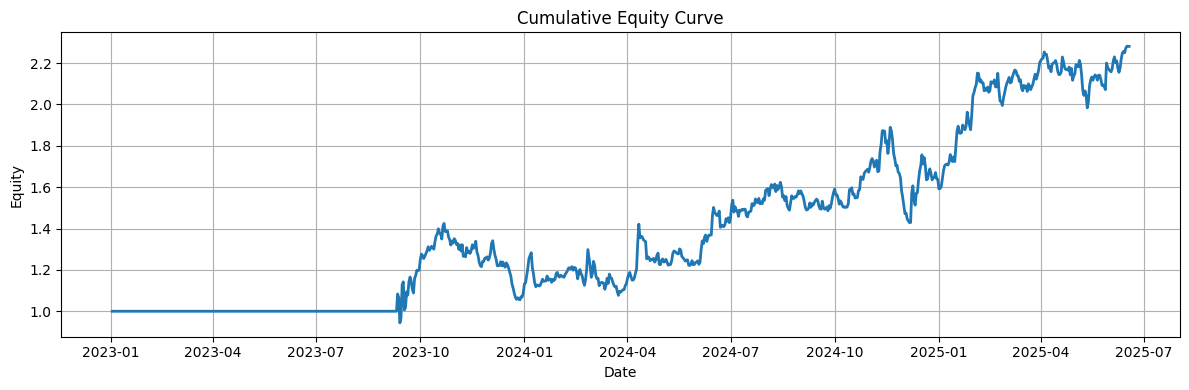

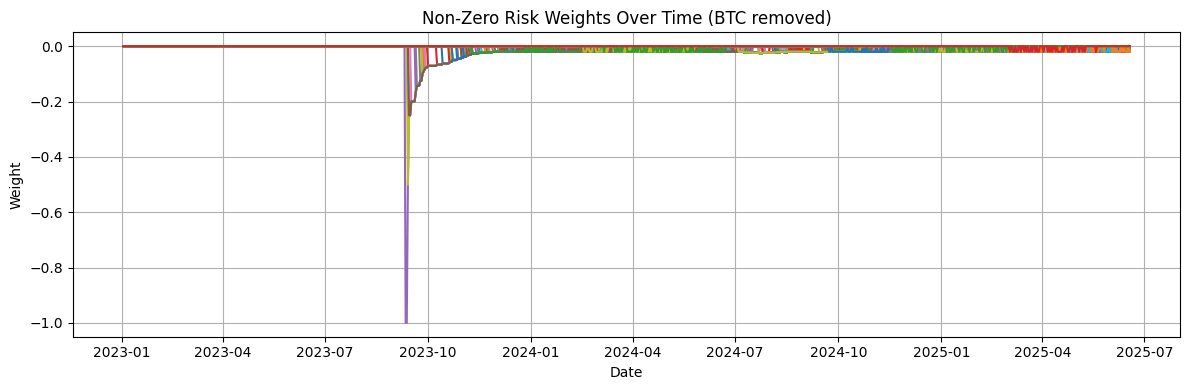

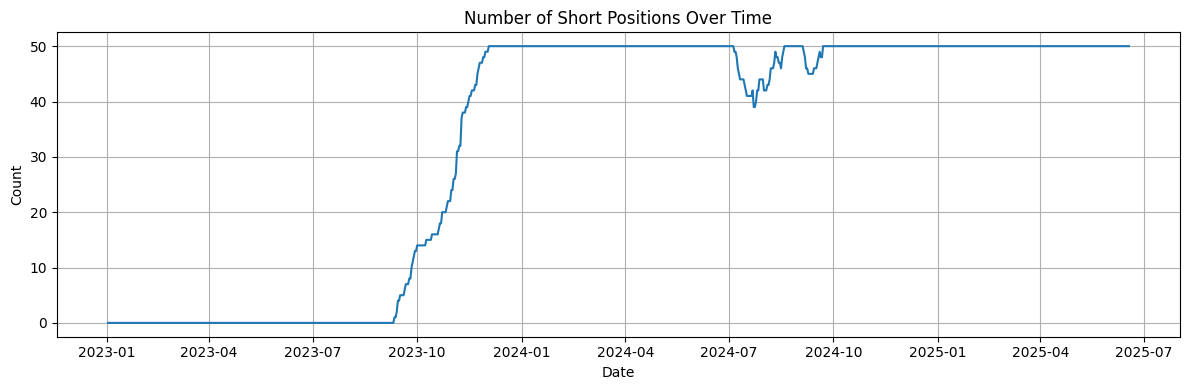

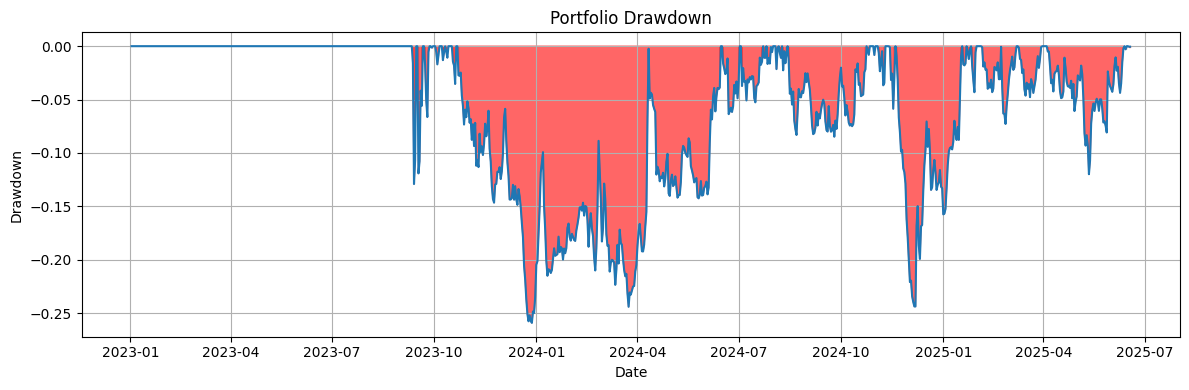

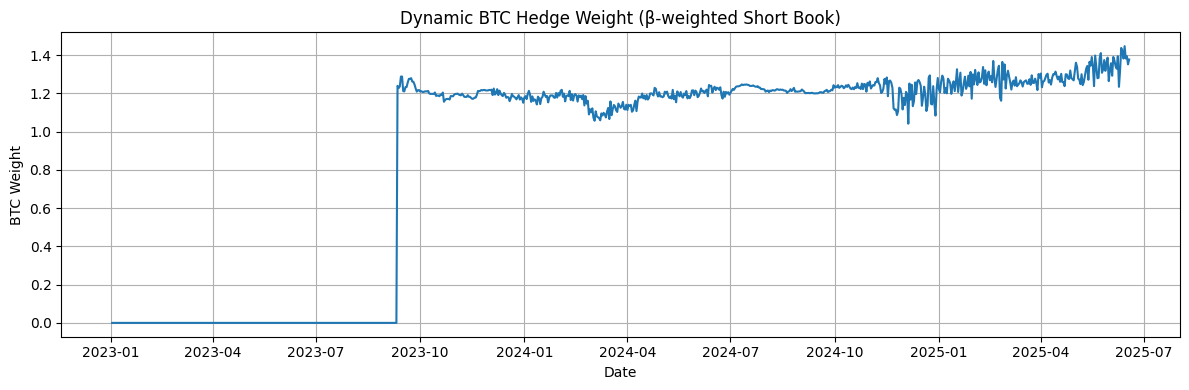

1.06 annualized Sharpe ratio


In [915]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------------------
# 1.  PREP
# ---------------------------------------------------------------------------
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(['timestamp', 'symbol'])
df = df[df.timestamp > '2023-01-01']          # back-test date filter

# ---------------------------------------------------------------------------
# 2.  DAILY RETURNS
# ---------------------------------------------------------------------------
df['ret'] = df.groupby('symbol')['close'].pct_change()   # from T-1 to T

# ---------------------------------------------------------------------------
# 3.  RISK-WEIGHTED SHORT BOOK  (sum(weights) = -1), capped at 50 positions,
#     now equal-weighted across those 50 worst idio_return shorts
# ---------------------------------------------------------------------------
def _risk_weights(day: pd.DataFrame, cap: int = 50) -> pd.Series:
    shorts = day['signal'] == -1
    if shorts.sum() == 0:
        return pd.Series(0.0, index=day.index)

    # pick up to `cap` coins with the lowest idio_return
    shorters = day.loc[shorts]
    to_keep = shorters.nsmallest(cap, 'idio_return').index

    # compute equal weights: each gets -1 / n
    n = len(to_keep)
    w = -1.0 / n if n > 0 else 0.0

    # full-day weight vector, zero for all others
    out = pd.Series(0.0, index=day.index)
    out.loc[to_keep] = w
    return out

df['weight'] = (
    df.groupby('timestamp', group_keys=False)
      .apply(lambda d: _risk_weights(d, cap=50))
)

# ---------------------------------------------------------------------------
# 4.  DYNAMIC BTC HEDGE WEIGHT  (offset the book’s β exactly)
#     btc_weight_t = − Σ_i weight_i,t × beta_i,t
# ---------------------------------------------------------------------------
beta_col = 'beta_ewm' if 'beta_ewm' in df.columns else 'beta'

btc_weight = (
    df.groupby('timestamp')
      .apply(lambda day: -(day['weight'] * day[beta_col]).sum())
      .rename('btc_weight')
)

# ---------------------------------------------------------------------------
# 5.  PIVOT WEIGHTS / RETURNS, LAG RETURNS
# ---------------------------------------------------------------------------
weights_df = df.pivot(index='timestamp', columns='symbol', values='weight').fillna(0.0)
weights_df['BTC'] = btc_weight.reindex(weights_df.index).fillna(0.0)

rets_df  = df.pivot(index='timestamp', columns='symbol', values='ret').fillna(0.0)
rets_lag = rets_df.shift(-1).fillna(0.0)                      # avoid look-ahead

# ---------------------------------------------------------------------------
# 6.  PORTFOLIO RETURNS & EQUITY CURVE
# ---------------------------------------------------------------------------
port_ret = (weights_df * rets_lag).sum(axis=1).rename('port_ret')
equity   = (1 + port_ret.cumsum()).rename('cum_equity')

# ---------------------------------------------------------------------------
# 7.  PLOTS
# ---------------------------------------------------------------------------

# (a) cumulative equity curve
plt.figure(figsize=(12, 4))
plt.plot(equity.index, equity, lw=2)
plt.title('Cumulative Equity Curve')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.grid(True)
plt.tight_layout()
plt.show()

# (b) non-zero risk weights over time (BTC removed)
nz = (weights_df
      .drop(columns='BTC', errors='ignore')
      .loc[:, lambda x: (x != 0).any(axis=0)])

plt.figure(figsize=(12, 4))
for sym in nz.columns:
    plt.plot(nz.index, nz[sym])
plt.title('Non-Zero Risk Weights Over Time (BTC removed)')
plt.xlabel('Date')
plt.ylabel('Weight')
plt.grid(True)
plt.tight_layout()
plt.show()

# (c) number of short positions
plt.figure(figsize=(12, 4))
plt.plot(nz.index, (nz != 0).sum(axis=1), lw=1.5)
plt.title('Number of Short Positions Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()

# (d) portfolio drawdown
running_max = equity.cummax()
drawdown = (equity / running_max) - 1

plt.figure(figsize=(12, 4))
plt.fill_between(drawdown.index, drawdown, 0, where=drawdown < 0,
                 color='red', alpha=0.6)
plt.plot(drawdown.index, drawdown, lw=1.5)
plt.title('Portfolio Drawdown')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.grid(True)
plt.tight_layout()
plt.show()

# (e) dynamic BTC hedge weight (β-adjusted)
plt.figure(figsize=(12, 4))
plt.plot(btc_weight.index, btc_weight, lw=1.5)
plt.title('Dynamic BTC Hedge Weight (β-weighted Short Book)')
plt.xlabel('Date')
plt.ylabel('BTC Weight')
plt.grid(True)
plt.tight_layout()
plt.show()

# ---------------------------------------------------------------------------
# 8.  ANNUALISED SHARPE
# ---------------------------------------------------------------------------
print(f"{(port_ret.mean() / port_ret.std()) * np.sqrt(365):.2f} annualized Sharpe ratio")
